# Targeting Direct Marketing with Amazon SageMaker XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_

---

---

## Contents

1. [Background](#Background)
1. [Prepration](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Exentsions](#Extensions)

---

## Background
Direct marketing, either through mail, email, phone, etc., is a common tactic to acquire customers.  Because resources and a customer's attention is limited, the goal is to only target the subset of prospects who are likely to engage with a specific offer.  Predicting those potential customers based on readily available information like demographics, past interactions, and environmental factors is a common machine learning problem.

This notebook presents an example problem to predict if a customer will enroll for a term deposit at a bank, after one or more phone calls.  The steps include:

* Preparing your Amazon SageMaker notebook
* Downloading data from the internet into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

---

## Preparation

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [2]:
# cell 02
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-dm'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now let's bring in the Python libraries that we'll use throughout the analysis

In [3]:
# cell 03
import sagemaker_datawrangler           # For interactive data prep widget
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

In [4]:
# cell 04
pd.__version__

'1.4.4'

Make sure pandas version is set to 1.2.4 or later. If it is not the case, restart the kernel before going further

---

## Data
Let's start by downloading the [direct marketing dataset](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip) from the sample data s3 bucket. 

\[Moro et al., 2014\] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


In [5]:
# cell 05
!wget https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip

with zipfile.ZipFile('bank-additional.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

--2023-09-01 05:29:29--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.92.250.58, 3.5.78.103, 3.5.84.162, ...
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.92.250.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip.1’

bank-additional.zip 100%[===================>] 422.68K  --.-KB/s    in 0.002s  

2023-09-01 05:29:29 (179 MB/s) - ‘bank-additional.zip.1’ saved [432828/432828]



Now lets read this into a Pandas data frame and take a look. Because we imported the `sagemaker_datawrangler` library we will automatically be able to view distributions, issues with the data, and other helpful recomendations and built in transformations. 

In [6]:
# cell 06
data = pd.read_csv('./bank-additional/bank-additional-full.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

Let's talk about the data.  At a high level, we can see:

* We have a little over 40K customer records, and 20 features for each customer
* The features are mixed; some numeric, some categorical
* The data appears to be sorted, at least by `time` and `contact`, maybe more

_**Specifics on each of the features:**_

*Demographics:*
* `age`: Customer's age (numeric)
* `job`: Type of job (categorical: 'admin.', 'services', ...)
* `marital`: Marital status (categorical: 'married', 'single', ...)
* `education`: Level of education (categorical: 'basic.4y', 'high.school', ...)

*Past customer events:*
* `default`: Has credit in default? (categorical: 'no', 'unknown', ...)
* `housing`: Has housing loan? (categorical: 'no', 'yes', ...)
* `loan`: Has personal loan? (categorical: 'no', 'yes', ...)

*Past direct marketing contacts:*
* `contact`: Contact communication type (categorical: 'cellular', 'telephone', ...)
* `month`: Last contact month of year (categorical: 'may', 'nov', ...)
* `day_of_week`: Last contact day of the week (categorical: 'mon', 'fri', ...)
* `duration`: Last contact duration, in seconds (numeric). Important note: If duration = 0 then `y` = 'no'.
 
*Campaign information:*
* `campaign`: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
* `pdays`: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
* `previous`: Number of contacts performed before this campaign and for this client (numeric)
* `poutcome`: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)

*External environment factors:*
* `emp.var.rate`: Employment variation rate - quarterly indicator (numeric)
* `cons.price.idx`: Consumer price index - monthly indicator (numeric)
* `cons.conf.idx`: Consumer confidence index - monthly indicator (numeric)
* `euribor3m`: Euribor 3 month rate - daily indicator (numeric)
* `nr.employed`: Number of employees - quarterly indicator (numeric)

*Target variable:*
* `y`: Has the client subscribed a term deposit? (binary: 'yes','no')

### Exploration
Let's start exploring the data in our data prep widget.  First, let's understand how the features are distributed.

Notice that:

* Almost 90% of the values for our target variable `y` are "no", so most customers did not subscribe to a term deposit.
* Many of the predictive features take on values of "unknown".  Some are more common than others.  We should think carefully as to what causes a value of "unknown" (are these customers non-representative in some way?) and how we that should be handled.
  * Even if "unknown" is included as it's own distinct category, what does it mean given that, in reality, those observations likely fall within one of the other categories of that feature?
* Many of the predictive features have categories with very few observations in them.  If we find a small category to be highly predictive of our target outcome, do we have enough evidence to make a generalization about that?
* Contact timing is particularly skewed.  Almost a third in May and less than 1% in December.  What does this mean for predicting our target variable next December?
* There are no missing values in our numeric features.  Or missing values have already been imputed.
  * `pdays` takes a value near 1000 for almost all customers.  Likely a placeholder value signifying no previous contact.
* Several numeric features have a very long tail.  Do we need to handle these few observations with extremely large values differently?
* Several numeric features (particularly the macroeconomic ones) occur in distinct buckets.  Should these be treated as categorical?

Next, let's look at how our features relate to the target that we are attempting to predict.

y                    no       yes
job                              
admin.         0.248167  0.291379
blue-collar    0.235745  0.137500
entrepreneur   0.036445  0.026724
housemaid      0.026103  0.022845
management     0.071030  0.070690
retired        0.035187  0.093534
self-employed  0.034804  0.032112
services       0.099759  0.069612
student        0.016417  0.059267
technician     0.164523  0.157328
unemployed     0.023804  0.031034
unknown        0.008017  0.007974
y               no       yes
marital                     
divorced  0.113166  0.102586
married   0.612783  0.545690
single    0.272190  0.349138
unknown   0.001861  0.002586
y                          no       yes
education                              
basic.4y             0.102550  0.092241
basic.6y             0.057568  0.040517
basic.9y             0.152457  0.101940
high.school          0.232133  0.222198
illiterate           0.000383  0.000862
professional.course  0.127175  0.128233
university.degree    0.287239 

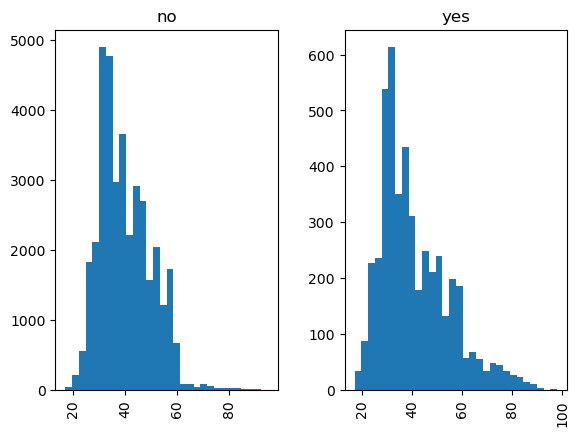

duration


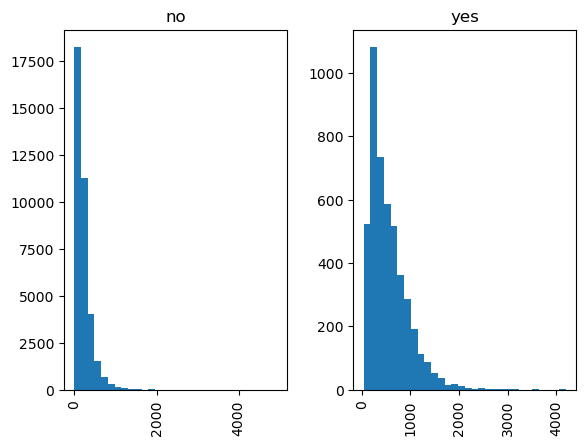

campaign


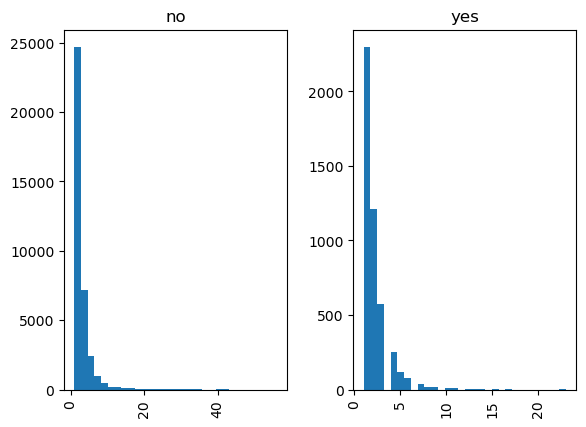

pdays


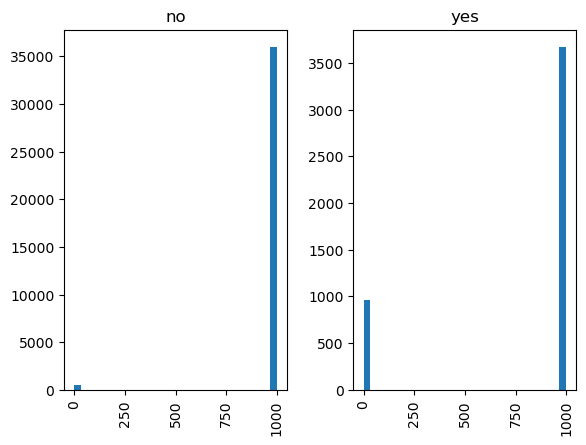

previous


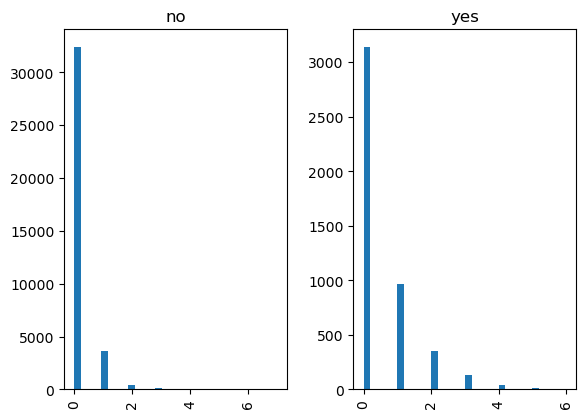

emp.var.rate


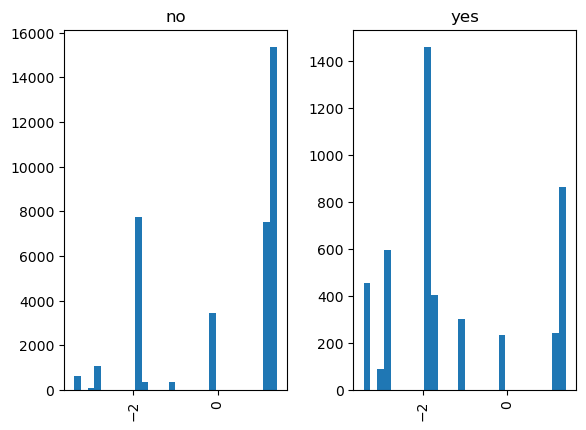

cons.price.idx


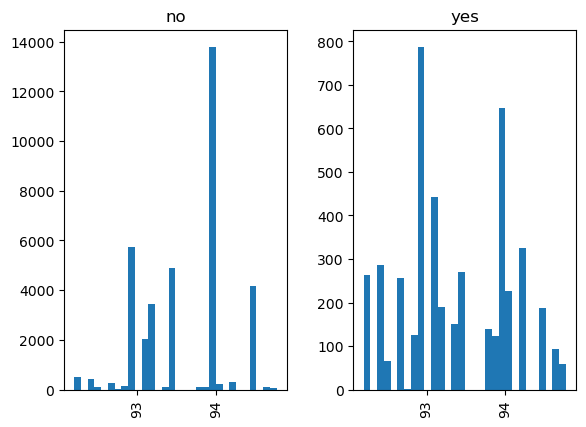

cons.conf.idx


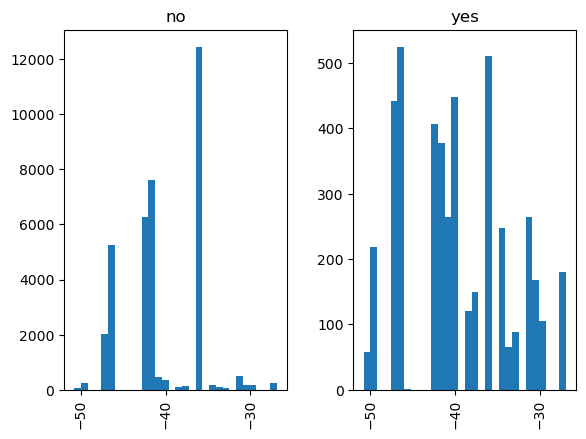

euribor3m


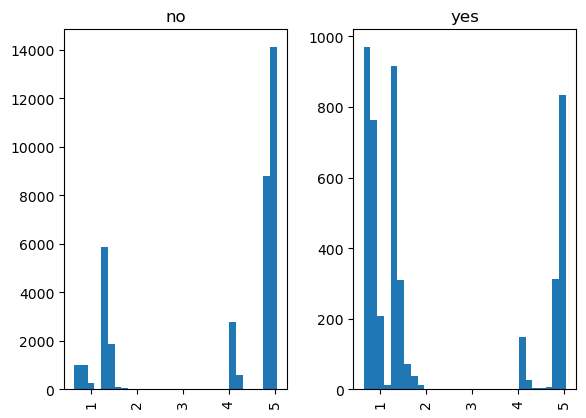

nr.employed


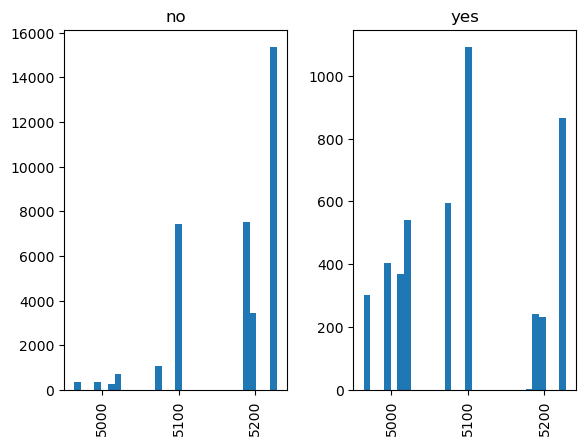

In [7]:
# cell 07
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        print(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

Notice that:

* Customers who are-- "blue-collar", "married", "unknown" default status, contacted by "telephone", and/or in "may" are a substantially lower portion of "yes" than "no" for subscribing.
* Distributions for numeric variables are different across "yes" and "no" subscribing groups, but the relationships may not be straightforward or obvious.

Now let's look at how our features relate to one another.

                     age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968        0.005312      -0.008173  -0.032897   
campaign            0.150754 

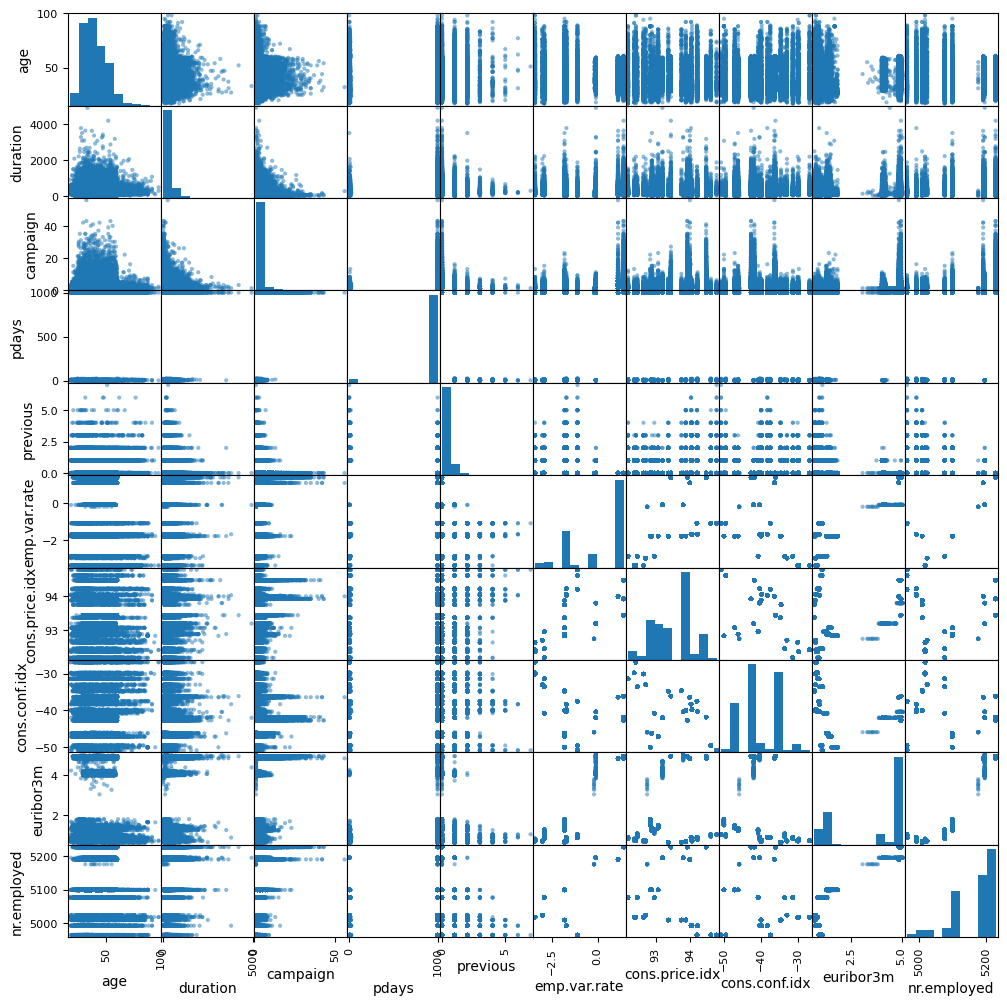

In [8]:
# cell 08
print(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

Notice that:
* Features vary widely in their relationship with one another.  Some with highly negative correlation, others with highly positive correlation.
* Relationships between features is non-linear and discrete in many cases.

### Transformation

Cleaning up data is part of nearly every machine learning project.  It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process.  Several common techniques include:

* Handling missing values: Some machine learning algorithms are capable of handling missing values, but most would rather not.  Options include:
 * Removing observations with missing values: This works well if only a very small fraction of observations have incomplete information.
 * Removing features with missing values: This works well if there are a small number of features which have a large number of missing values.
 * Imputing missing values: Entire [books](https://www.amazon.com/Flexible-Imputation-Missing-Interdisciplinary-Statistics/dp/1439868247) have been written on this topic, but common choices are replacing the missing value with the mode or mean of that column's non-missing values.
* Converting categorical to numeric: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.
* Oddly distributed data: Although for non-linear models like Gradient Boosted Trees, this has very limited implications, parametric models like regression can produce wildly inaccurate estimates when fed highly skewed data.  In some cases, simply taking the natural log of the features is sufficient to produce more normally distributed data.  In others, bucketing values into discrete ranges is helpful.  These buckets can then be treated as categorical variables and included in the model when one hot encoded.
* Handling more complicated data types: Mainpulating images, text, or data at varying grains is left for other notebook templates.

Luckily, some of these aspects have already been handled for us, and the algorithm we are showcasing tends to do well at handling sparse or oddly distributed data.  Therefore, let's keep pre-processing simple.

In [9]:
# cell 09

# Note: These transformations can be done through the graphical widget that we generated above. The data prep widget will automatically generate code for transformations that you do.
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed


In [10]:
# cell 10
model_data = pd.get_dummies(data)                                                                  # Convert categorical variables to sets of indicators

Another question to ask yourself before building a model is whether certain features will add value in your final use case.  For example, if your goal is to deliver the best prediction, then will you have access to that data at the moment of prediction?  Knowing it's raining is highly predictive for umbrella sales, but forecasting weather far enough out to plan inventory on umbrellas is probably just as difficult as forecasting umbrella sales without knowledge of the weather.  So, including this in your model may give you a false sense of precision.

Following this logic, let's remove the economic features and `duration` from our data as they would need to be forecasted with high precision to use as inputs in future predictions.

Even if we were to use values of the economic indicators from the previous quarter, this value is likely not as relevant for prospects contacted early in the next quarter as those contacted later on.

In [11]:
# cell 11
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

When building a model whose primary goal is to predict a target value on new data, it is important to understand overfitting.  Supervised learning models are designed to minimize error between their predictions of the target value and actuals, in the data they are given.  This last part is key, as frequently in their quest for greater accuracy, machine learning models bias themselves toward picking up on minor idiosyncrasies within the data they are shown.  These idiosyncrasies then don't repeat themselves in subsequent data, meaning those predictions can actually be made less accurate, at the expense of more accurate predictions in the training phase.

The most common way of preventing this is to build models with the concept that a model shouldn't only be judged on its fit to the data it was trained on, but also on "new" data.  There are several different ways of operationalizing this, holdout validation, cross-validation, leave-one-out validation, etc.  For our purposes, we'll simply randomly split the data into 3 uneven groups.  The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

In [12]:
# cell 12
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%
list(test_data.columns)

['age',
 'campaign',
 'pdays',
 'previous',
 'no_previous_contact',
 'not_working',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'd

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [13]:
# cell 13
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
pd.concat([test_data['y_yes'], test_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [14]:
# cell 14
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

---

## End of Lab 1


---

## Training
Now we know that most of our features have skewed distributions, some are highly correlated with one another, and some appear to have non-linear relationships with our target variable.  Also, for targeting future prospects, good predictive accuracy is preferred to being able to explain why that prospect was targeted.  Taken together, these aspects make gradient boosted trees a good candidate algorithm.

There are several intricacies to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models.  By doing this the collection of simple models can actually outperform large, complex models.  Other Amazon SageMaker notebooks elaborate on gradient boosting trees further and how they differ from similar algorithms.

`xgboost` is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using Amazon SageMaker's managed, distributed training framework.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [15]:
# cell 15
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [16]:
# cell 16
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator.  This includes:
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data
1. Algorithm hyperparameters

And then a `.fit()` function which specifies:
1. S3 location for output data.  In this case we have both a training and validation set which are passed in.

In [17]:
# cell 17
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2023-09-01 05:33:59 Starting - Starting the training job...
2023-09-01 05:34:24 Starting - Preparing the instances for training......
2023-09-01 05:35:26 Downloading - Downloading input data...
2023-09-01 05:35:51 Training - Downloading the training image.....Arguments: train
[2023-09-01:05:36:44:INFO] Running standalone xgboost training.
[2023-09-01:05:36:44:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 8578.01mb
[2023-09-01:05:36:44:INFO] Determined delimiter of CSV input is ','
[05:36:44] S3DistributionType set as FullyReplicated
[05:36:44] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-09-01:05:36:44:INFO] Determined delimiter of CSV input is ','
[05:36:44] S3DistributionType set as FullyReplicated
[05:36:44] 8238x59 matrix with 486042 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[05:36:44] src/tree/updater_prune.cc:74: tre

---

## Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [18]:
# cell 18
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

------!

---

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values.  In this case, we're simply predicting whether the customer subscribed to a term deposit (`1`) or not (`0`), which produces a simple confusion matrix.

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [19]:
# cell 19
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [20]:
# cell 20
def predict(data, predictor, rows=500 ):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy(), xgb_predictor)

Now we'll check our confusion matrix to see how well we predicted versus actuals.

In [21]:
# cell 21
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions   0.0  1.0
actuals               
0            3583   53
1             382  101

So, of the ~4000 potential customers, we predicted 136 would subscribe and 94 of them actually did.  We also had 389 subscribers who subscribed that we did not predict would.  This is less than desirable, but the model can (and should) be tuned to improve this.  Most importantly, note that with minimal effort, our model produced accuracies similar to those published [here](https://core.ac.uk/download/pdf/55631291.pdf).

_Note that because there is some element of randomness in the algorithm's subsample, your results may differ slightly from the text written above._

### Clean Up
Delete any resources you created in this notebook that you no longer wish to use.

In [22]:
# cell 22
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

--
## Serverless Deployment (Optional)
After training the model, retrieve the model artifacts so that we can deploy the model to an endpoint.

In [23]:
# Setup clients
import boto3

client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")

In [24]:
# Retrieve model data from training job
model_artifacts = xgb.model_data
model_artifacts

's3://sagemaker-us-west-2-793803570670/sagemaker/DEMO-xgboost-dm/output/xgboost-2023-09-01-05-33-58-913/output/model.tar.gz'

### Model Creation
Create a model by providing your model artifacts, the container image URI, environment variables for the container (if applicable), a model name, and the SageMaker IAM role.

In [25]:
from time import gmtime, strftime

model_name = "xgboost-serverless" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)

# dummy environment variables
byo_container_env_vars = {"SAGEMAKER_CONTAINER_LOG_LEVEL": "20", "SOME_ENV_VAR": "myEnvVar"}

create_model_response = client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": container,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": byo_container_env_vars,
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

Model name: xgboost-serverless2023-09-01-05-44-39
Model Arn: arn:aws:sagemaker:us-west-2:793803570670:model/xgboost-serverless2023-09-01-05-44-39


### Endpoint Configuration Creation
This is where you can adjust the Serverless Configuration for your endpoint. The current max concurrent invocations for a single endpoint, known as MaxConcurrency, can be any value from 1 to 200, and MemorySize can be any of the following: 1024 MB, 2048 MB, 3072 MB, 4096 MB, 5120 MB, or 6144 MB.

In [26]:
xgboost_epc_name = "xgboost-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=xgboost_epc_name,
    ProductionVariants=[
        {
            "VariantName": "byoVariant",
            "ModelName": model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-west-2:793803570670:endpoint-config/xgboost-serverless-epc2023-09-01-05-44-48


### Serverless Endpoint Creation
Now that we have an endpoint configuration, we can create a serverless endpoint and deploy our model to it. When creating the endpoint, provide the name of your endpoint configuration and a name for the new endpoint.

In [27]:
endpoint_name = "xgboost-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=xgboost_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-west-2:793803570670:endpoint/xgboost-serverless-ep2023-09-01-05-44-56


Wait until the endpoint status is InService before invoking the endpoint.

In [28]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'xgboost-serverless-ep2023-09-01-05-44-56',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:793803570670:endpoint/xgboost-serverless-ep2023-09-01-05-44-56',
 'EndpointConfigName': 'xgboost-serverless-epc2023-09-01-05-44-48',
 'ProductionVariants': [{'VariantName': 'byoVariant',
   'DeployedImages': [{'SpecifiedImage': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
     'ResolvedImage': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost@sha256:0c8f830ac408e6dee08445fb60392e9c3f05f790a4b3c07ec22327c08f75bcbf',
     'ResolutionTime': datetime.datetime(2023, 9, 1, 5, 44, 57, 645000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 4096, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 9, 1, 5, 44, 57, 98000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 9, 1, 5, 46, 45, 11000, tzinfo=tzlocal()

### Endpoint Invocation
Invoke the endpoint by sending a request to it. The following is a sample data point grabbed from the CSV file downloaded from the Direct Marketing dataset.

In [29]:
payload = b"3., 999.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0., 0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1., 0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1., 0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0., 0.,   1.,   0."

response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType="text/csv",
)

print(response["Body"].read())

b'0.06702394783496857'


### Clean Up
Delete any resources you created in this notebook that you no longer wish to use.

In [ ]:
client.delete_model(ModelName=model_name)
client.delete_endpoint_config(EndpointConfigName=xgboost_epc_name)
client.delete_endpoint(EndpointName=endpoint_name)

## Automatic model Tuning (optional)
Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.
For example, suppose that you want to solve a binary classification problem on this marketing dataset. Your goal is to maximize the area under the curve (auc) metric of the algorithm by training an XGBoost Algorithm model. You don't know which values of the eta, alpha, min_child_weight, and max_depth hyperparameters to use to train the best model. To find the best values for these hyperparameters, you can specify ranges of values that Amazon SageMaker hyperparameter tuning searches to find the combination of values that results in the training job that performs the best as measured by the objective metric that you chose. Hyperparameter tuning launches training jobs that use hyperparameter values in the ranges that you specified, and returns the training job with highest auc.


In [ ]:
# cell 22
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}


In [ ]:
# cell 23
objective_metric_name = 'validation:auc'

In [ ]:
# cell 24
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)


In [ ]:
# cell 25
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
# cell 26
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [ ]:
# cell 27
# return the best training job name
tuner.best_training_job()

In [ ]:
# cell 28
#  Deploy the best trained or user specified model to an Amazon SageMaker endpoint
tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

In [ ]:
# cell 29
# Create a serializer
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [ ]:
# cell 30
# Predict
predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy(),tuner_predictor)

In [ ]:
# cell 31
# Collect predictions and convert from the CSV output our model provides into a NumPy array
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

---

## Extensions

This example analyzed a relatively small dataset, but utilized Amazon SageMaker features such as distributed, managed training and real-time model hosting, which could easily be applied to much larger problems.  In order to improve predictive accuracy further, we could tweak value we threshold our predictions at to alter the mix of false-positives and false-negatives, or we could explore techniques like hyperparameter tuning.  In a real-world scenario, we would also spend more time engineering features by hand and would likely look for additional datasets to include which contain customer information not available in our initial dataset.

### (Optional) Clean-up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
# cell 33
tuner_predictor.delete_endpoint(delete_endpoint_config=True)